In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

print('PyTorch version:', torch.__version__)
print('torchvision verseion:', torchvision.__version__)
print('Is GPU avaibale:', torch.cuda.is_available())

PyTorch version: 1.0.0
torchvision verseion: 0.2.1
Is GPU avaibale: True


In [2]:
# settings
batchsize = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# データセットの準備
# Tensorにしつつ、 (-1 ~ 1)の範囲に正規化
tf = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# データセットをロード
# 本当はtraining data, validation data, test dataに分けるべきだが、今回は簡便のため2つに分ける.
mnist_train = datasets.MNIST(root = '../../data/MNIST',
                                 train = True,
                                 transform = tf,
                                 download = False)
mnist_validation = datasets.MNIST(root = '../../data/MNIST',
                                      train = False,
                                      transform = tf)

mnist_train_loader = DataLoader(mnist_train, batch_size = batchsize, shuffle = True)
mnist_validation_loader = DataLoader(mnist_validation, batch_size = batchsize, shuffle = False)

print('the number of training data:', len(mnist_train))
print('the number of validation data:', len(mnist_validation))

the number of training data: 60000
the number of validation data: 10000


torch.Size([1, 28, 28])


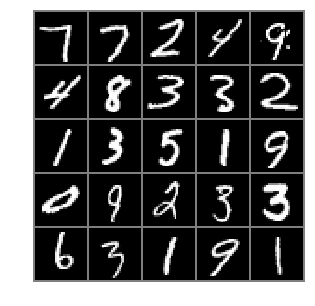

In [14]:
def show_image(img):
    npimg = img.numpy() * 0.5 + 0.5
    plt.figure(figsize = (5, 5))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
images, labels = iter(mnist_train_loader).next()
show_image(make_grid(images[:25], nrow=5, padding=1))
print(images[0].size())

In [28]:
class ActNorm2d(nn.Module):
    def __init__(self, num_features):
        super(Actnorm2d, self).__init__()
        size = [1, num_features, 1, 1]
        self.register_parameter('bias', nn.Parameter(torch.zeros(*size)))
        self.register_parameter('log_s', nn.Parameter(torch.zeros(*size)))
        self.inited = False
        
    def forward(self, x):
        if not self.inited:
            self.initialize_parameters(x)
        
        z = (x + self.bias) * torch.exp(self.log_s)
        log_det_jacobian = calculate_log_det_jacobian(x)
        return z, log_det_jacobian
    
    def inverse(self, z):
        x = z / torch.exp(self.log_s) - self.bias

    def calculate_log_det_jacobian(self, x):
        h = x.size(2)
        w = x.size(3)
        return h * w * torch.sum(self.log_s)
    
    def initialize_parameters(self, first_minibatch_x):
        if not self.training:
            return
        
        with torch.no_grad():
            bias = -1.0 * multidim_mean(first_minibatch_x.clone(), dim=[0, 2, 3])
            var_s = multidim_mean((first_minibatch_x.clone() + bias) ** 2, dim=[0, 2, 3])
            log_s = torch.log(1 / (torch.sqrt(var_s) + 1e-6))
            self.bias.data.copy_(bias.data)
            self.log_s.data.copy_(log_s.data)
            self.inited = True
            
    def multidim_mean(self, tensor, dim):
        dim = sorted(dim)
        for d in dim:
            tensor = tensor.mean(dim=d, keepdim=True)
        return tensor

In [18]:
class Invertible1x1Conv2d(nn.Module):
    def __init__(self, num_features):
        super(Invertible1x1Conv2d, self).__init__()
        
    def forward(self, x):
        1+1
    def inverse(self, z):
        1+1
        
    def _calculate_log_det_jacobian(self, x):
        1+1
        


In [20]:
class CouplingLayer(nn.Module):
    def __init__(self, affine=True):
        super(CouplingLayer, self).__init__()
        
    def forward(self, x):
        1+1
    def inverse(self, z):
        1+1
        
    def _calculate_log_det_jacobian(self, x):
        1+1


In [24]:
class StepofFlow(nn.Module):
    def __init__(self, num_features, affine=True):
        super(StepofFlow, self).__init__()

    def forward(self, x):
        1+1
    def inverse(self, z):
        1+1

In [ ]:
class Glow(nn.Module):
    def __init__(self):
        super(Glow, self).__init__()
        
    def forward(self, x):
        1+1
    
    def inverse(self, z):
        1+1

In [ ]:
class 

In [5]:
# 1x1 invertible convolution　
# これLU分解使ってなくね？
class Invertible1x1Conv2d(nn.Module):
    def __init__(self, c):
        super(Invertible1x1Conv, self).__init__()
        self.conv = nn.Conv1d(c, c, kernel_size=1, stride=1, padding=0, bias=False)
        
        # 直交行列から初期値をサンプル
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        
        # ヤコビアンが-1ではなく1であることを保証（偶数の正方行列に対しては−１，奇数なら1になるっぽい？）
        if torch.det(W) < 0:
            W[:,0] = -W[:,0]
        
        self.conv.weight.data = W.view(c, c, 1)
        
    def forward(self, z, reverse=False):
        batch_size, group_size, n_of_group = z.size()
        
        # self.conv.weightのサイズが[height, width, 1]なので調整（下のunsqueeze()も同じ）
        W = self.conv.weight.squeeze(2)
        
        # 推論処理（サンプリング）
        if reverse:
            # 推論処理なので一回逆行列を計算したら以後やらない
            if not hasattr(self, 'w_inverse'):
                W_inverse = W.inverse() # 逆行列を計算
                W_inverse = torch.autograd.Variable(W_inverse.unsqueeze(2)) # このVariableいる？
                self.W_inverse = W_inverse
            z = F.conv1d(z, self.W_inverse, bias=None, stride=1, padding=0)
            return z
        
        # 学習のためのforward処理（データ→ガウス分布方向）
        else:
            # Wは畳込みでバッチサイズ×チャネル内の要素数 回適用されるのでかける（1x1畳み込みのため）
            # バッチサイズかけるのマジ？意味分からん
            log_det_W = batch_size * n_of_group * torch.logdet(W)
            return self.conv(z), log_det_W

In [6]:
sorted([3,3,2,1])

[1, 2, 3, 3]

In [21]:
def fire(a=1, b):
    return a+b

SyntaxError: non-default argument follows default argument (<ipython-input-21-7205fe510423>, line 1)